In [10]:
import os
import numpy as np
import cv2
import scipy.io as sio
import nibabel as nib
import matplotlib.pyplot as plt
from nibabel.testing import data_path
from sklearn.decomposition import PCA
from nilearn.masking import compute_epi_mask
from nilearn.plotting import plot_roi
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# function for loading the data and transposing the dimensions
def load_data(filename):
    test_img = nib.load(filename)
    test_data = np.array(test_img.dataobj)

    # change the shape
    test_data = np.transpose(test_data)
    
    return test_data

(184, 30, 64, 64)


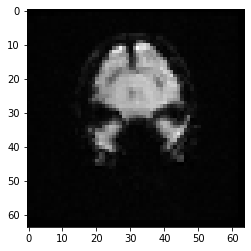

In [5]:
# check the shape of the data
test_filename= "/content/drive/MyDrive/Columbia/1.Courses/2021_Fall/STAT5293/HW/HW3/data/sub-01_ses-test_task-fingerfootlips_bold.nii"
retest_filename= "/content/drive/MyDrive/Columbia/1.Courses/2021_Fall/STAT5293/HW/HW3/data/sub-01_ses-retest_task-fingerfootlips_bold.nii"

test_data = load_data(test_filename)
print(test_data.shape)

retest_data = load_data(retest_filename)

# plot a slice 
plt.imshow(test_data[70,6,:,:], cmap='gray');

In [6]:
# function for creating masks
def create_mask(data, threshold):
    data[data < threshold] = 0
    return data

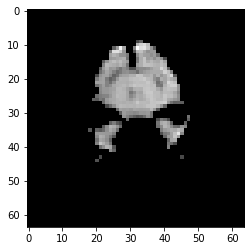

In [7]:
# plot the mask to see the difference
mask_500 = create_mask(test_data, 500)
plt.imshow(mask_500[70,6,:,:], cmap='gray')

In [8]:
# get the y values
old_labels = sio.loadmat("/content/drive/MyDrive/Columbia/1.Courses/2021_Fall/STAT5293/HW/HW3/data/label.mat")
old_labels = old_labels['label']

labels = []
for label in old_labels:
    labels.append(label[0])

# check the number of y values equals the number of image dataset
print("number of labels:", len(labels))

number of labels: 184


In [9]:
# feature extraction
# extract the values of 30 slices into one vector
def feature_extraction(data):
    vec = data.reshape((184,-1))
    return vec

In [10]:
# main function without PCA
def classify(mask):
    # extract features
    X = feature_extraction(mask)

    # SVM
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)
    
    svc = SVC()
    svc.fit(X_train, y_train)
    preds = svc.predict(X_test)
    
    # k-folds validation
    # hypertuning with different C values for SVM using grid search
    
    params = {"C": [100,1000],
              "gamma": [1e-09]}
    gscv = GridSearchCV(svc,
                        param_grid = params,
                        cv = 5,
                        refit = True)
    gscv.fit(X_train, y_train)
    print(gscv.best_params_)

    scores = cross_val_score(gscv.best_estimator_, X_train, y_train, cv=5)
    print("mean validation accuracy:", scores.mean())

    # use the best model on the test dataset
    #print("test data accuracy:", gscv.best_estimator_.score(X_test, y_test))

    return gscv.best_params_, scores.mean()

In [11]:
# main function
def classify_pca(mask, n):
    # extract features
    X = feature_extraction(mask)
    
    # PCA
    pca = PCA(n_components=n)
    X = pca.fit_transform(X)
    
    # SVM
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)
    
    svc = SVC()
    svc.fit(X_train, y_train)
    preds = svc.predict(X_test)
    
    # k-folds validation
    # hypertuning with different C values for SVM using grid search

    params = {"C": np.logspace(0, 10, 11),
              "gamma": np.logspace(-9, 3, 13)}
    gscv = GridSearchCV(svc,
                        param_grid = params,
                        cv = 5,
                        refit = True)
    gscv.fit(X_train, y_train)
    print(gscv.best_params_)

    scores = cross_val_score(gscv.best_estimator_, X_train, y_train, cv=5)
    print("mean validation accuracy:", scores.mean())

    # use the best model on the test dataset
    #print("test data accuracy:", gscv.best_estimator_.score(X_test, y_test))

    return gscv.best_params_, scores.mean()

In [12]:
# hyperparameter tuning with different parameters without PCA (test dataset)
# 1. threshold, 2. C(SVM), 3. gamma(SVM)
thresholds = [100, 200, 300, 400, 500]

scores_test = []
for threshold in thresholds:
    mask = create_mask(test_data, threshold)
    print("threshold:", threshold)
    score = classify(mask)
    print("\n")
    
    scores_test.append((threshold, score))

threshold: 100
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.8843678160919539


threshold: 200
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.7687356321839081


threshold: 300
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.7963218390804597


threshold: 400
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.8363218390804598


threshold: 500
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.7827586206896552




In [13]:
# hyperparameter tuning with different parameters with PCA (test dataset)
# 1. threshold, 2. n_components(PCA), 3. C(SVM), 4. gamma(SVM)
thresholds = [100, 200, 300, 400, 500]
n_components = [10, 50 ,100]

scores_test_pca = []
for threshold in thresholds:
    mask = create_mask(test_data, threshold)
    for n in n_components:
        print("threshold:", threshold, ", n_components:", n)
        score = classify_pca(mask, n)
        print("\n")

        scores_test_pca.append((threshold, n, score))

threshold: 100 , n_components: 10
{'C': 100000.0, 'gamma': 1e-09}
mean validation accuracy: 0.74183908045977


threshold: 100 , n_components: 50
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.8308045977011493


threshold: 100 , n_components: 100
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.8160919540229885


threshold: 200 , n_components: 10
{'C': 10000.0, 'gamma': 1e-09}
mean validation accuracy: 0.789655172413793


threshold: 200 , n_components: 50
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.8094252873563217


threshold: 200 , n_components: 100
{'C': 100.0, 'gamma': 1e-09}
mean validation accuracy: 0.843448275862069


threshold: 300 , n_components: 10
{'C': 10000.0, 'gamma': 1e-09}
mean validation accuracy: 0.7480459770114942


threshold: 300 , n_components: 50
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.7758620689655171


threshold: 300 , n_components: 100
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.8841379310344827



In [14]:
# hyperparameter tuning with different parameters without PCA (retest dataset)
# 1. threshold, 2. C(SVM), 3. gamma(SVM)
thresholds = [100, 200, 300, 400, 500]

scores_retest = []
for threshold in thresholds:
    mask = create_mask(retest_data, threshold)
    print("threshold:", threshold)
    score = classify(mask)
    print("\n")

    scores_retest.append((threshold, score))

threshold: 100
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.6873563218390805


threshold: 200
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.7004597701149425


threshold: 300
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.6933333333333334


threshold: 400
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.6813793103448276


threshold: 500
{'C': 100, 'gamma': 1e-09}
mean validation accuracy: 0.7073563218390805




In [15]:
# hyperparameter tuning with different parameters (retest dataset)
# 1. threshold, 2. n_components(PCA), 3. C(SVM), 4. gamma(SVM)
thresholds = [100, 200, 300, 400, 500]
n_components = [10, 50 ,100]

scores_retest_pca = []
for threshold in thresholds:
    mask = create_mask(retest_data, threshold)
    for n in n_components:
        print("threshold:", threshold, ", n_components:", n)
        score = classify_pca(mask, n)
        print("\n")

        scores_retest_pca.append((threshold, n, score))

threshold: 100 , n_components: 10
{'C': 100000.0, 'gamma': 1e-09}
mean validation accuracy: 0.6193103448275863


threshold: 100 , n_components: 50
{'C': 100.0, 'gamma': 1e-09}
mean validation accuracy: 0.7004597701149425


threshold: 100 , n_components: 100
{'C': 100.0, 'gamma': 1e-09}
mean validation accuracy: 0.7473563218390804


threshold: 200 , n_components: 10
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.6671264367816091


threshold: 200 , n_components: 50
{'C': 10.0, 'gamma': 1e-08}
mean validation accuracy: 0.7222988505747127


threshold: 200 , n_components: 100
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.7354022988505747


threshold: 300 , n_components: 10
{'C': 100000.0, 'gamma': 1e-09}
mean validation accuracy: 0.6193103448275863


threshold: 300 , n_components: 50
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.6928735632183909


threshold: 300 , n_components: 100
{'C': 1000.0, 'gamma': 1e-09}
mean validation accuracy: 0.7416091954022989


In [16]:
# function for getting the best score
def best_score(score_list):
    max_score = max([sublist[-1][-1] for sublist in score_list])
    
    for i, sublist in enumerate(score_list):
        if max_score in sublist[-1]:
            best_param = score_list[i]
            break
    
    return best_param

In [17]:
# overall result summary
print("Model without PCA on ses-test \n", best_score(scores_test))
print("Model with PCA on ses-test \n", best_score(scores_test_pca))
print("Model without PCA on ses-retest \n", best_score(scores_retest))
print("Model with PCA on ses-retest \n", best_score(scores_retest_pca))

Model without PCA on ses-test 
 (100, ({'C': 100, 'gamma': 1e-09}, 0.8843678160919539))
Model with PCA on ses-test 
 (300, 100, ({'C': 1000.0, 'gamma': 1e-09}, 0.8841379310344827))
Model without PCA on ses-retest 
 (500, ({'C': 100, 'gamma': 1e-09}, 0.7073563218390805))
Model with PCA on ses-retest 
 (500, 100, ({'C': 100.0, 'gamma': 1e-09}, 0.7680459770114942))


In [18]:
"""
# Extra Credit
# best params were threshold=500, n_components=50, C=100, gamma=1e-09
threshold = 100
n = 100
C= 100
gamma = 1e-09
mask = create_mask(test_data, threshold)
X = feature_extraction(mask)

# PCA
#pca = PCA(n_components=n)
#X = pca.fit_transform(X)

# SVM
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)

svc = SVC(C=100, gamma = 1e-09)
svc.fit(X_train, y_train)

# load retest data with threshold=500
# dimension reduction with n_components=50

mask_test = create_mask(retest_data, threshold)
X_retest = feature_extraction(mask_test)

#pca = PCA(n_components=n)
#X_retest = pca.fit_transform(X_retest)
preds = svc.predict(X_retest)

metrics.accuracy_score(preds, labels)

#scores = cross_val_score(svc, X_retest, labels, cv=5)
#print("k-folds accuracy:", scores.mean())
"""

'\n# Extra Credit\n# best params were threshold=500, n_components=50, C=100, gamma=1e-09\nthreshold = 100\nn = 100\nC= 100\ngamma = 1e-09\nmask = create_mask(test_data, threshold)\nX = feature_extraction(mask)\n\n# PCA\n#pca = PCA(n_components=n)\n#X = pca.fit_transform(X)\n\n# SVM\nX_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)\n\nsvc = SVC(C=100, gamma = 1e-09)\nsvc.fit(X_train, y_train)\n\n# load retest data with threshold=500\n# dimension reduction with n_components=50\n\nmask_test = create_mask(retest_data, threshold)\nX_retest = feature_extraction(mask_test)\n\n#pca = PCA(n_components=n)\n#X_retest = pca.fit_transform(X_retest)\npreds = svc.predict(X_retest)\n\nmetrics.accuracy_score(preds, labels)\n\n#scores = cross_val_score(svc, X_retest, labels, cv=5)\n#print("k-folds accuracy:", scores.mean())\n'

In [19]:
# tried creating a function with pipeline to implement different n_components for PCA values 
# but the code took too long for some reason, so I just used a for loop
"""
# main function
def classify(mask):
    # extract features
    X = feature_extraction(mask)
    
    # SVM
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)
    
    pipe = make_pipeline(PCA(), SVC()) # standardize values
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    # k-folds validation
    # hypertuning with different C values for SVM using grid search

    params = {"pca__n_components": np.array(range(10,110,10)),
              "svc__C": np.logspace(0, 10, 11),
              "svc__gamma": np.logspace(-9, 3, 13)}
    gscv = GridSearchCV(pipe,
                        param_grid = params,
                        cv = 5,
                        refit = True)
    gscv.fit(X_train, y_train)
    print(gscv.best_params_)

    scores = cross_val_score(gscv.best_estimator_, X_train, y_train, cv=5)
    print("k-folds accuracy:", scores.mean())

    # use the best model on the test dataset
    print("test data accuracy:", gscv.best_estimator_.score(X_test, y_test))
"""

'\n# main function\ndef classify(mask):\n    # extract features\n    X = feature_extraction(mask)\n    \n    # SVM\n    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)\n    \n    pipe = make_pipeline(PCA(), SVC()) # standardize values\n    pipe.fit(X_train, y_train)\n    preds = pipe.predict(X_test)\n    \n    # k-folds validation\n    # hypertuning with different C values for SVM using grid search\n\n    params = {"pca__n_components": np.array(range(10,110,10)),\n              "svc__C": np.logspace(0, 10, 11),\n              "svc__gamma": np.logspace(-9, 3, 13)}\n    gscv = GridSearchCV(pipe,\n                        param_grid = params,\n                        cv = 5,\n                        refit = True)\n    gscv.fit(X_train, y_train)\n    print(gscv.best_params_)\n\n    scores = cross_val_score(gscv.best_estimator_, X_train, y_train, cv=5)\n    print("k-folds accuracy:", scores.mean())\n\n    # use the best model on the test dataset\n    print("te